In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import DMatrix
from xgboost import XGBRegressor
from xgboost import cv
from xgboost import plot_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from model import correlation_matrix
from model import split_transform_data
from model import regression_plot

## Model of pearlite start - upper

In [4]:
df = pd.read_csv('datasets/ps-upper-training.csv')

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,1263.0,1042.461599,105.945707,870.00000,980.000000,1000.00000,1090.000000,1260.000000
C,1263.0,0.215970,0.174053,0.06000,0.110000,0.13000,0.250000,0.930000
Mn,1263.0,0.369976,0.166530,0.00000,0.290000,0.40000,0.490000,1.000000
Cu,1263.0,0.007031,0.022906,0.00000,0.000000,0.00000,0.000000,0.090000
Si,1263.0,0.393127,0.350337,0.00000,0.300000,0.37000,0.440000,2.200000
Ni,1263.0,0.215392,0.201542,0.00000,0.120000,0.15000,0.340000,1.770000
Cr,1263.0,14.509675,3.595243,10.50000,12.400000,13.12000,13.800000,24.850000
Mo,1263.0,0.114766,0.325490,0.00000,0.000000,0.00000,0.020000,1.350000
V,1263.0,0.018543,0.069040,0.00000,0.000000,0.00000,0.000000,0.310000
Al,1263.0,0.000180,0.001430,0.00000,0.000000,0.00000,0.000000,0.013000


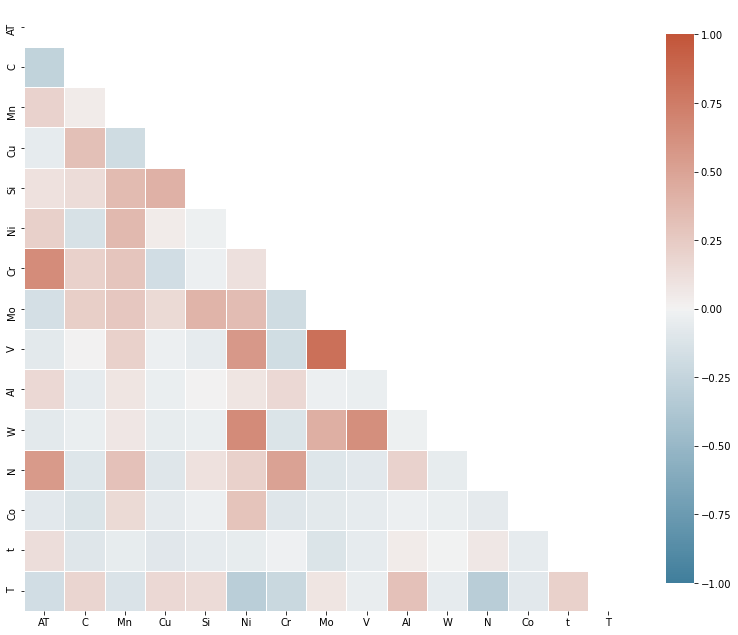

In [6]:
_ = correlation_matrix(df)

In [7]:
names = df.columns.tolist()
y_names = names.pop(-1)
X_names = names.copy()

X = df[X_names].to_numpy()
y = df[y_names].to_numpy()

rets = split_transform_data(X, y, test_size=0.3, random_state=42)
X_train, X_tests, y_train, y_tests, scaler = rets

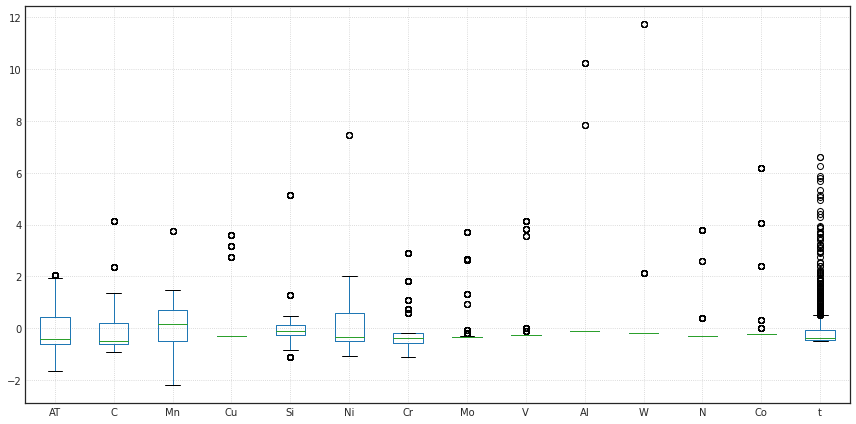

In [8]:
tmp = pd.DataFrame(X_train, columns=X_names)

plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(12, 6))
_ = tmp.boxplot(column=X_names, ax=ax)
ax.grid(linestyle=':')
fig.tight_layout()

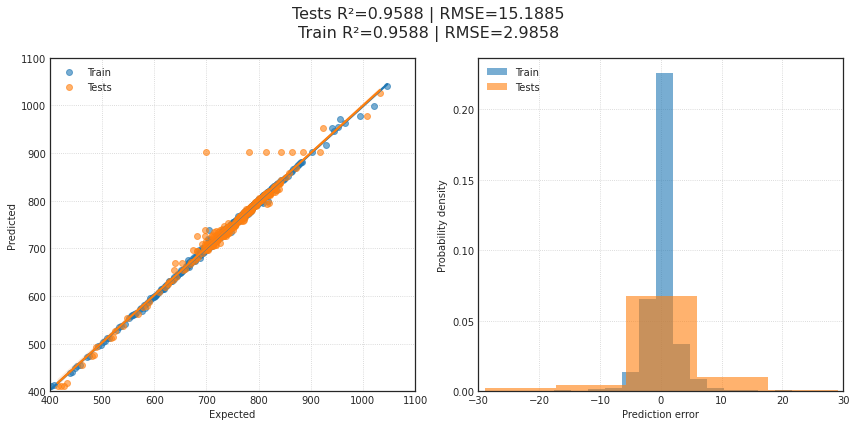

In [25]:
rnd = RandomForestRegressor(n_estimators=10)
rnd.fit(X_train, y_train)
_ = regression_plot(rnd, X_train, X_tests, y_train, y_tests,
                    lims_corr=(400, 1100), x_lim_hist=(-30, +30))

### XGBoost

In [10]:
dmatrix_train = DMatrix(data=X_train, label=y_train,
                        feature_names=X_names)
# dmatrix_tests = DMatrix(data=X_tests, label=y_tests,
#                         feature_names=X_names)

In [11]:
rounds = 1000

nfold = 10

param_dist = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.8,
#     'reg_lambda': 2,
#     'reg_alpha': 5,
#     'tree_method': 'auto',
    'num_parallel_tree': 1
}

In [12]:
cv_results = cv(
    dtrain=dmatrix_train, 
    params=param_dist,
    nfold=nfold,
    num_boost_round=rounds,
    early_stopping_rounds=10,
    metrics='rmse',
    as_pandas=True,
    seed=42
)

cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
995,3.898590,0.178434,7.178701,1.081799
996,3.892373,0.179422,7.172222,1.079954
997,3.887395,0.180497,7.168616,1.078914
998,3.883282,0.180495,7.165201,1.077291
999,3.878301,0.181517,7.161090,1.075664


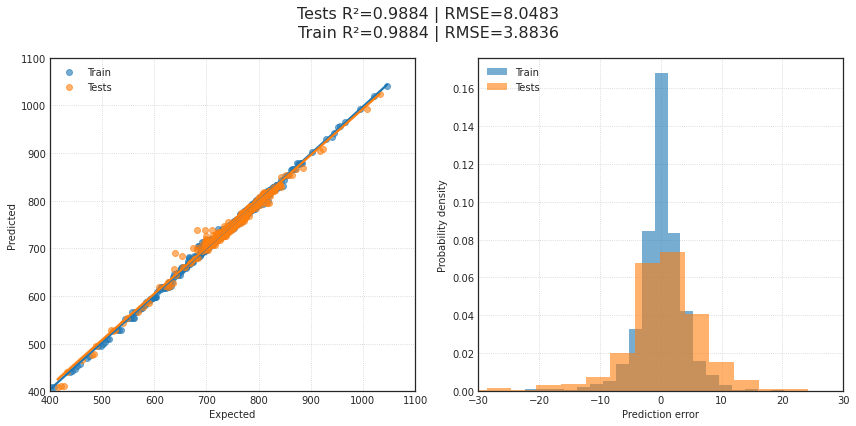

In [22]:
xgb = XGBRegressor(n_estimators=1000, **param_dist)
xgb.fit(X_train, y_train)
_ = regression_plot(xgb, X_train, X_tests, y_train, y_tests,
                    lims_corr=(400, 1100), x_lim_hist=(-30, +30))

['AT', 'C', 'Mn', 'Cu', 'Si', 'Ni', 'Cr', 'Mo', 'V', 'Al', 'W', 'N', 'Co', 't']


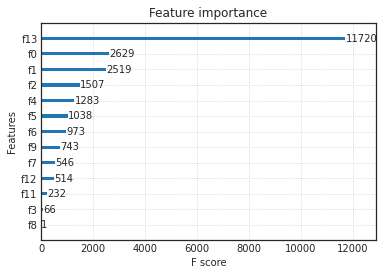

In [14]:
print(X_names)
plot_importance(xgb)
plt.grid(linestyle=':')

### Validate pearlite end - lower

In [15]:
def validate_set(model, df):
    """ Perform validation of dataset with model. """
    X_valid = df[X_names].to_numpy()
    y_valid = df[y_names].to_numpy()
    X_valid = scaler.apply_to(X_valid)
    regression_plot(model, None, X_valid, None, y_valid,
                    lims_corr=(None, None), x_lim_hist=(None, None))

In [16]:
df1 = pd.read_csv('datasets/ps-upper-validation-1.csv')
df2 = pd.read_csv('datasets/ps-upper-validation-2.csv')
df3 = pd.read_csv('datasets/ps-upper-validation-3.csv')
df4 = pd.read_csv('datasets/ps-upper-validation-4.csv')
df5 = pd.read_csv('datasets/ps-upper-validation-5.csv')

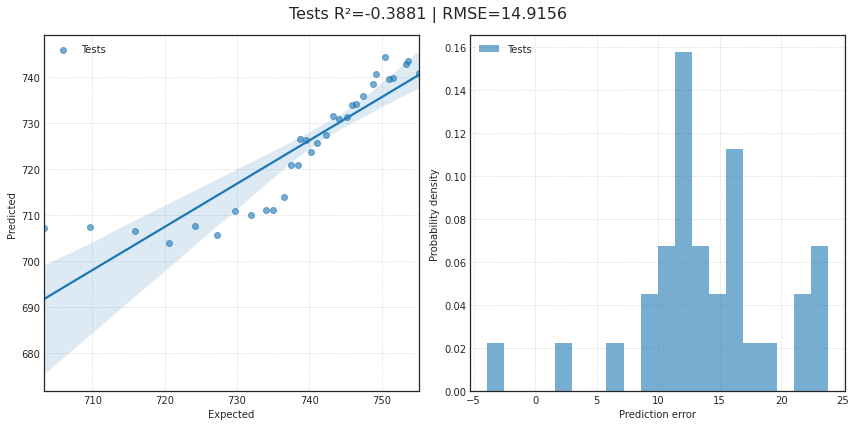

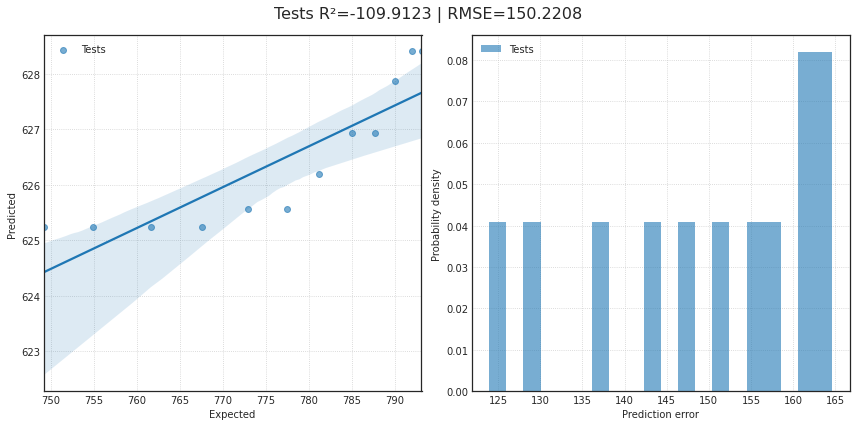

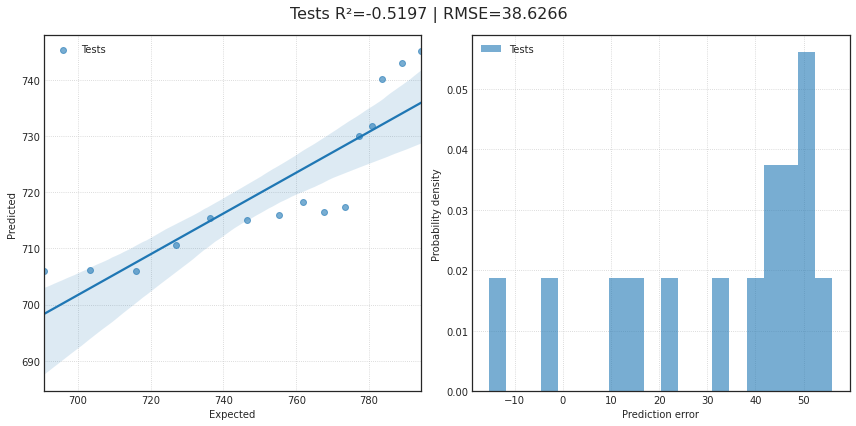

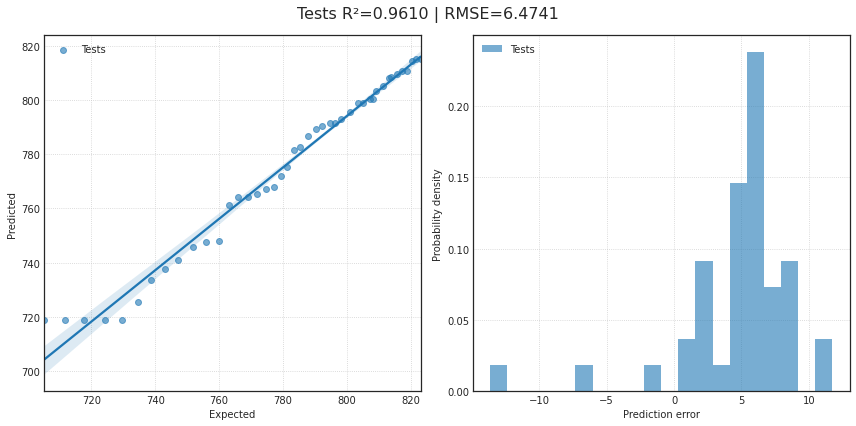

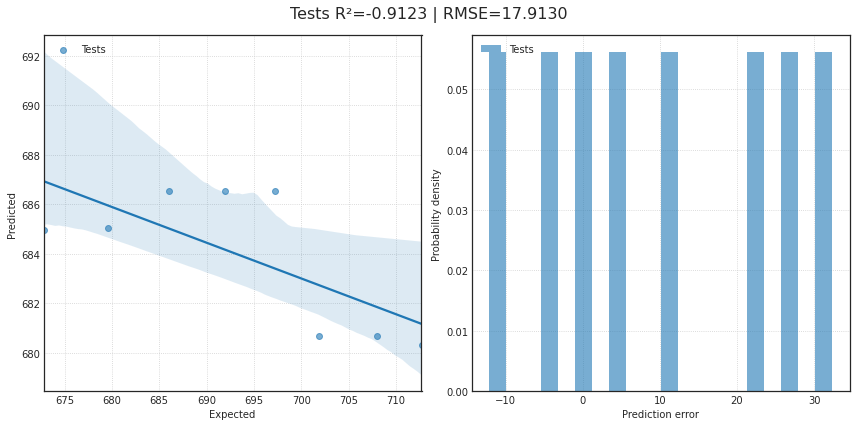

In [17]:
validate_set(xgb, df1)
validate_set(xgb, df2)
validate_set(xgb, df3)
validate_set(xgb, df4)
validate_set(xgb, df5)

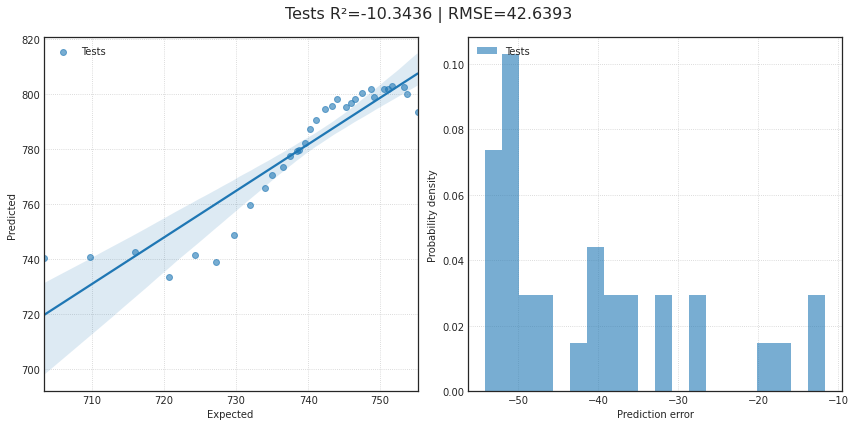

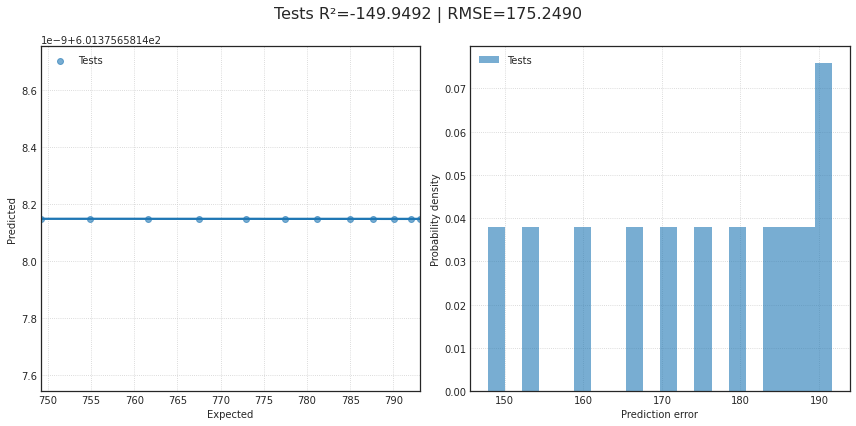

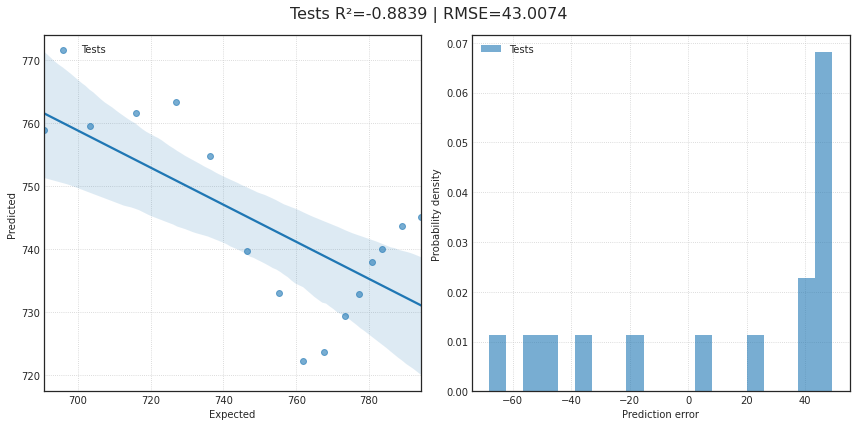

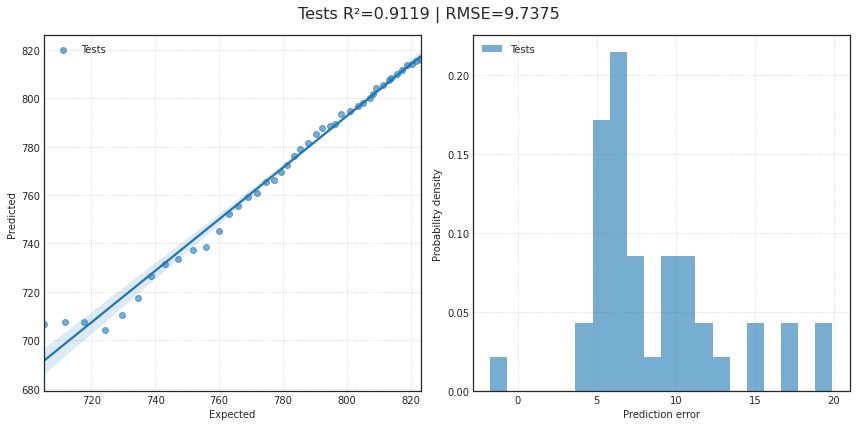

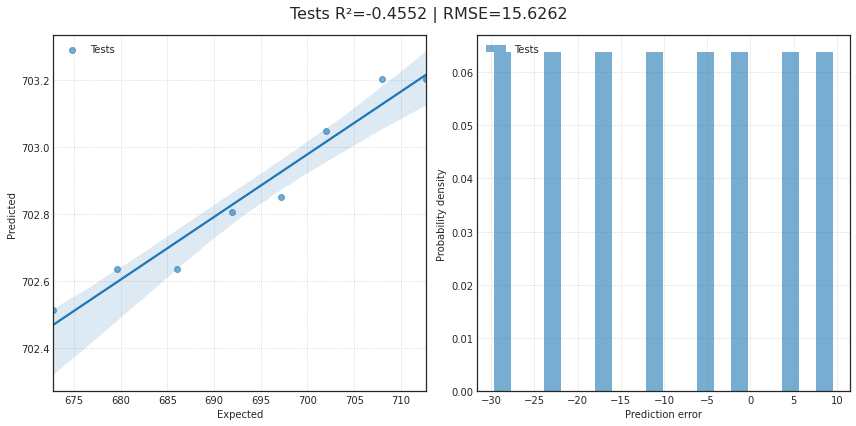

In [18]:
validate_set(rnd, df1)
validate_set(rnd, df2)
validate_set(rnd, df3)
validate_set(rnd, df4)
validate_set(rnd, df5)